This is an simplified version of Saulius Simcikas's [model](https://forum.effectivealtruism.org/posts/L5EZjjXKdNgcm253H/corporate-campaigns-affect-9-to-120-years-of-chicken-life) of the cost effectiveness of the Animal Welfare's corportate campaigning activities to get companies to pledge to use cage-free eggs. 

In this example model, the total-cost input is drawn from Salius's guesstimate distribution.  This model also only covers egg-laying hens, while Salius's also adresses broiler's chickens.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
# To find module in parent directory
sys.path.append('..')
import simulator as sim

# Model Building

First we define the model, _M_.

We can create normally-distributed parameters with the `simulator.Parameter.normal()` function, either passing in a mean and standard deviation or a confidence interval (and corresponding confidence-level, assumed to be 90%).  These distributions can then be combined through use of normal python operators `+, -, *, \`.  There is currently no support anything except these basic operations and (log)normal distributions.

While not required it is helpful to use the function `Model.add_params()` to give names to parameters.  The function `Model.add_inputs()` is similar except that it should be used when the parameter intuitively corresponds to an input to the model.  This can be used to see which inputs an output is most sensitive to, for instance.

In [7]:
M = sim.Model()

# The Parameter class, for easy access to creation routines for Parameter objects. 
P = sim.Parameter

# First we calculate the number of hens that would be affected with 100% commtiment rate
us_commitments = P.normal(ci=[210e6, 270e6])
us_p_cage_free_anyway = P.lognormal(ci=[.18, .26])
us_counterfactual = us_commitments * (1 - us_p_cage_free_anyway)

int_commitments = P.lognormal(ci=[100e6, 300e6])
int_p_cage_free_anyway = P.normal(ci=[.2, .5])
int_counterfactual = int_commitments * (1 - int_p_cage_free_anyway)

tot_counterfactual = us_counterfactual + int_counterfactual

# We can register the adjustable input parameters alongside engish names/descriptions
# This will potentially happen automatically in the future, unsure exactly what makes sense
M.add_inputs({
    "us commitments (hens)": us_commitments,
    "us proportion cage free anyway": us_p_cage_free_anyway,
    "international commitments (hens)": int_commitments,
    "international proportion cage free anyway": int_p_cage_free_anyway
})


# Total spending is taken by sampling outputs from the guesstimate distribution in order to not
# have to replicate the whole calculation.  This is done by copy and pasting samples from
# guesstimateinto a file which can then be read by our model.
# `P.sample_dist(list)` just randomly samples outcomes from `list`
tot_spending = P.sample_dist(np.loadtxt("spending samples.txt"))
ideal_per_dollar_per_year = tot_counterfactual / tot_spending

us_follow_through = P.lognormal(ci=[.33, .85])
int_follow_through = P.normal(ci=[.63, .9])

# The follow through rate (a weighted average of us and internation follow through)
follow_through = (us_follow_through*us_counterfactual + \
    int_follow_through* int_counterfactual) / tot_counterfactual

hens_per_year_per_dollar = follow_through * ideal_per_dollar_per_year
years_of_impact = P.lognormal(ci=[4, 36])

# Our final output
hen_years_per_dollar = hens_per_year_per_dollar * years_of_impact

M.add_inputs({
    "total spending": tot_spending,
    "us follow through": us_follow_through,
    "international follow through": int_follow_through,
    "years of impact": years_of_impact
})
M.add_params({
    "US counterfactual": us_counterfactual,
    "Interational counterfactual": int_counterfactual,
    "Total counterfactual": tot_counterfactual,
    "Follow through": follow_through,
    "Hens per year, per dollar": hens_per_year_per_dollar,
    "Hen years affected per dollar": hen_years_per_dollar
})

This is a simple way to illustrate what sub-calculations a particular parameter of interest depends on.  It will only list parameters that are named with either `add_inputs()` or `add_params()`. While this is intended to be a full feature at some point, it currently does not deal with many edgecases and can be unweildy, especially when a parameter depends on the same sub-caluclation in multiple ways (e.g. "Total counterfactual" below).

In [8]:
def print_parents(param, prefix="- "):
    if param.name is not None:
        print(prefix + param.name)
    for parent in param.parents:
        if parent.name is None:
            print_parents(parent, prefix)
        else:
            print_parents(parent, '\t' + prefix)
        
print_parents(hen_years_per_dollar)

- Hen years affected per dollar
	- Hens per year, per dollar
		- Follow through
			- us follow through
			- US counterfactual
				- us commitments (hens)
				- us proportion cage free anyway
			- international follow through
			- Interational counterfactual
				- international commitments (hens)
				- international proportion cage free anyway
			- Total counterfactual
				- US counterfactual
					- us commitments (hens)
					- us proportion cage free anyway
				- Interational counterfactual
					- international commitments (hens)
					- international proportion cage free anyway
		- Total counterfactual
			- US counterfactual
				- us commitments (hens)
				- us proportion cage free anyway
			- Interational counterfactual
				- international commitments (hens)
				- international proportion cage free anyway
		- total spending
	- years of impact


# Model Analysis

Now that we've created the model we can graph the sampled results for parameters of interest:

5th:  5.41
mean: 47.64
95th: 152.62

std: 60.6164



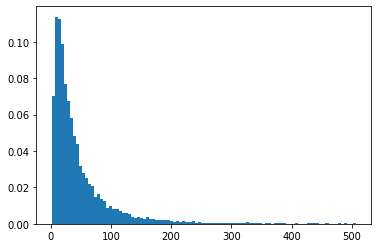

In [9]:
hen_years_per_dollar.print_summary();

We can also graph the correlations between one variable and all the input distributions.  Note this uses the english names that we registered the input variables with!

In [10]:
M.input_r2s(hen_years_per_dollar);

Input                                         r^2
-----------------------------------------  ------
years of impact                            0.5398
us follow through                          0.0557
international commitments (hens)           0.0446
total spending                             0.0302
us proportion cage free anyway             0.0028
international proportion cage free anyway  0.0022
international follow through               0.0005
us commitments (hens)                      0.0005


Or look at scatterplots for the correlations between two variables:

slope: 2.8971011079075297
intercept: -0.19122114979298033
r^2: 0.5398015550583193


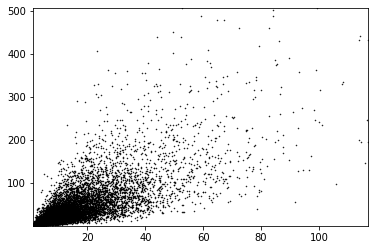

In [11]:
M.sensitivity(years_of_impact, hen_years_per_dollar)

Or create a graph comparing the outcome for the lowest 10% of sampled inputs for total spending (blue) to the highest 10% (orange).

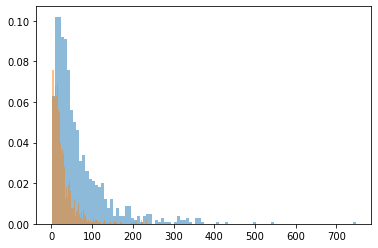

In [12]:
M.sensitivty_comparisons(tot_spending, hen_years_per_dollar)